# Context Veracity using Politifact dataset


Fake news can take on many forms, including photoshopped images, fake user-generated content or spoofed accounts, network-based content designed to appeal to a particular organization or group, as well as knowledge-based stories that contain a scientific or reasonable explanation of unresolved issues, often resulting in the spread of false information.

The factor chosen for Fake news detection is Context veracity. The dataset used is scrapped data from Politifact. Along with scraping the news addtional source information for the news is also scrapped.

To determince context veracity we need to find evidence for the news topic.

### Import Libraries

In [ ]:
import pandas as pd
import numpy as np
import csv
import gensim
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.preprocessing import StandardScaler
from nltk.stem.wordnet import WordNetLemmatizer
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix
from nltk.stem.porter import PorterStemmer
from sklearn import metrics
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.pipeline import Pipeline
from nltk.corpus import stopwords
from string import punctuation
import seaborn as sns
import pandas as pd
import numpy as np
import nltk
import re
import nltk
nltk.download('stopwords')
nltk.download('averaged_perceptron_tagger')
import matplotlib.pyplot as plt
from scipy import sparse

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.


In [ ]:
from google.colab import drive
drive.mount("/content/drive")


Mounted at /content/drive


##Import Posts data collected

In [ ]:
df = pd.read_csv("NEWS.csv",sep=',')

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1500 entries, 0 to 1499
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Unnamed: 0  1500 non-null   int64 
 1   Statement   1500 non-null   object
 2   Link        1500 non-null   object
 3   Date        1500 non-null   object
 4   Source      1500 non-null   object
 5   Label       1500 non-null   object
dtypes: int64(1), object(5)
memory usage: 70.4+ KB


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1500 entries, 0 to 1499
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Unnamed: 0  1500 non-null   int64 
 1   Statement   1500 non-null   object
 2   Link        1500 non-null   object
 3   Date        1500 non-null   object
 4   Source      1500 non-null   object
 5   Label       1500 non-null   object
dtypes: int64(1), object(5)
memory usage: 70.4+ KB


In [ ]:
df.head()

,Unnamed: 0,Statement,Link,Date,Source,Label
0,0,"Says “132,000 ballots in Fulton County, Ga., h...",https://www.politifact.com/factchecks/2020/nov...,"mber 10, 2020",Viral image,false
1,1,Says there are “indications of grossly imprope...,https://www.politifact.com/factchecks/2020/nov...,"mber 10, 2020",Dan Bishop,false
2,2,A “system glitch” in Wisconsin that “swapped v...,https://www.politifact.com/factchecks/2020/nov...,"mber 10, 2020",Eric Trump,false
3,3,"Overnight, election workers “found” 140,000 ma...",https://www.politifact.com/factchecks/2020/nov...,"mber 10, 2020",Facebook posts,false
4,4,Says CNN video shows “HAMMER / Scorecard Voter...,https://www.politifact.com/factchecks/2020/nov...,"mber 10, 2020",Pamela Geller,pants-fire


In [ ]:
df.shape

(1500, 6)

##Scrape Source Information for the Posts

###Scraping in Batches

In [ ]:
import urllib.request,sys,time
from bs4 import BeautifulSoup
import requests
import pandas as pd

pagesToGet= 50
#pagesToGet= 2
upperframe=[]  
for page in range(0,pagesToGet):
    print('processing page :', page+1)
    link = df['Link'][page]
    url = str(link)+'#sources'
    print(url)
    
    
    #an exception might be thrown, so the code should be in a try-except block
    try:
        #use the browser to get the url. This is suspicious command that might blow up.
        curr_page=requests.get(url)  
        #print(page.text)                           # this might throw an exception if something goes wrong.
    
    except Exception as e:                                   # this describes what to do if an exception is thrown
        error_type, error_obj, error_info = sys.exc_info()      # get the exception information
        print ('ERROR FOR LINK:',url)                          #print the link that cause the problem
        print (error_type, 'Line:', error_info.tb_lineno)     #print error info and line that threw the exception
        continue                                              #ignore this page. Abandon this and go back.
    time.sleep(2)   
    soup=BeautifulSoup(curr_page.text,'html.parser')
    frame=[]
    #links=soup.find_all('li',attrs={'class':'o-listicle__item'})
    
    article_tag=soup.find('article',attrs={'class':'m-superbox__content'})
    article_title=soup.find('div',attrs={'class':'m-statement__quote'})
    #print(len(links))
    filename="News_Sources1.csv"
    f=open(filename,"w", encoding = 'utf-8')
    headers="Title, Author, Author_Link\n"
    f.write(headers)
    
    

    authors = article_tag.find_all("p")
    for author in authors:
      Title = article_title.text.strip()
      Author = author.text.strip()
      if(author.find('a')):
        Author_Link = author.find('a')['href'].strip()
      else:
        Author_Link = '0'
      frame.append((Title,Author,Author_Link))
      f.write(Title+","+Author+","+Author_Link+"\n")
    upperframe.extend(frame)
f.close()


processing page : 1
https://www.politifact.com/factchecks/2020/nov/11/viral-image/no-132000-georgia-ballots-werent-likely-ineligable/#sources
processing page : 2
https://www.politifact.com/factchecks/2020/nov/10/dan-bishop/north-carolina-republican-falsely-accuses-election/#sources
processing page : 3
https://www.politifact.com/factchecks/2020/nov/10/eric-trump/no-biden-didnt-win-wisconsin-because-glitch-swappe/#sources
processing page : 4
https://www.politifact.com/factchecks/2020/nov/10/facebook-posts/election-workers-didnt-find-biden-votes-overnight-/#sources
processing page : 5
https://www.politifact.com/factchecks/2020/nov/10/pamela-geller/debunking-hammer-and-scorecard-election-fraud-cons/#sources
processing page : 6
https://www.politifact.com/factchecks/2020/nov/10/roger-polack/no-more-people-kenosha-county-did-not-die-covid-19/#sources
processing page : 7
https://www.politifact.com/factchecks/2020/nov/10/eric-trump/no-rock-county-did-not-have-glitch-stole-votes-tru/#sources
pro

In [ ]:
data1=pd.DataFrame(upperframe, columns=['Title','Author','Author_Link'])
data1.to_csv('News_Sources1.csv')
data1.head()

,Title,Author,Author_Link
0,"Says “132,000 ballots in Fulton County, Ga., h...","CNN, ""Georgia GOP lieutenant governor says ‘no...",https://edition.cnn.com/2020/11/09/politics/ge...
1,"Says “132,000 ballots in Fulton County, Ga., h...","Facebook post, Nov. 8, 2020",https://www.facebook.com/TheHipHopPatriot/post...
2,"Says “132,000 ballots in Fulton County, Ga., h...","Gateway Pundit, ""132,000 ballots in Fulton Cou...",https://www.thegatewaypundit.com/2020/11/huge-...
3,"Says “132,000 ballots in Fulton County, Ga., h...","LinkedIn profile, accessed Nov. 10, 2020",https://www.linkedin.com/in/richardbaris
4,"Says “132,000 ballots in Fulton County, Ga., h...","Red State Nation, ""Allegedly there are 132k ch...",https://redstatenation.com/allegedly-there-are...


In [ ]:
import urllib.request,sys,time
from bs4 import BeautifulSoup
import requests
import pandas as pd

pagesToGet= 100
#pagesToGet= 2
upperframe=[]  
for page in range(50,pagesToGet):
    print('processing page :', page+1)
    link = df['Link'][page]
    url = str(link)+'#sources'
    print(url)
    
    
    #an exception might be thrown, so the code should be in a try-except block
    try:
        #use the browser to get the url. This is suspicious command that might blow up.
        curr_page=requests.get(url)  
        #print(page.text)                           # this might throw an exception if something goes wrong.
    
    except Exception as e:                                   # this describes what to do if an exception is thrown
        error_type, error_obj, error_info = sys.exc_info()      # get the exception information
        print ('ERROR FOR LINK:',url)                          #print the link that cause the problem
        print (error_type, 'Line:', error_info.tb_lineno)     #print error info and line that threw the exception
        continue                                              #ignore this page. Abandon this and go back.
    time.sleep(2)   
    soup=BeautifulSoup(curr_page.text,'html.parser')
    frame=[]
    #links=soup.find_all('li',attrs={'class':'o-listicle__item'})
    
    article_tag=soup.find('article',attrs={'class':'m-superbox__content'})
    article_title=soup.find('div',attrs={'class':'m-statement__quote'})
    #print(len(links))
    filename="News_Sources2.csv"
    f=open(filename,"w", encoding = 'utf-8')
    headers="Title, Author, Author_Link\n"
    f.write(headers)
    
    

    authors = article_tag.find_all("p")
    for author in authors:
      Title = article_title.text.strip()
      Author = author.text.strip()
      if(author.find('a')):
        Author_Link = author.find('a')['href'].strip()
      else:
        Author_Link = '0'
      frame.append((Title,Author,Author_Link))
      f.write(Title+","+Author+","+Author_Link+"\n")
    upperframe.extend(frame)
f.close()


processing page : 51
https://www.politifact.com/factchecks/2020/nov/05/viral-image/north-carolina-and-wisconsin-did-not-have-more-vot/#sources
processing page : 52
https://www.politifact.com/factchecks/2020/nov/04/eric-trump/eric-trump-retweets-video-falsely-claiming-man-bur/#sources
processing page : 53
https://www.politifact.com/factchecks/2020/nov/04/donald-trump/no-president-trump-ballot-dumps-key-states-were-no/#sources
processing page : 54
https://www.politifact.com/factchecks/2020/nov/04/facebook-posts/fact-checking-conspiracy-theory-about-ballot-count/#sources
processing page : 55
https://www.politifact.com/factchecks/2020/nov/04/tweets/viral-tweet-spreads-false-information-about-mail-b/#sources
processing page : 56
https://www.politifact.com/factchecks/2020/nov/04/facebook-posts/no-nevada-did-not-stop-counting-ballots/#sources
processing page : 57
https://www.politifact.com/factchecks/2020/nov/04/viral-image/no-these-fivethirtyeight-graphs-dont-prove-voter-f/#sources
processin

In [ ]:
data2=pd.DataFrame(upperframe, columns=['Title','Author','Author_Link'])
data2.to_csv('News_Sources2.csv')
data2.head()

,Title,Author,Author_Link
0,"Asks, “How is this possible?” with a chart sho...","Ballotpedia, ""Voter registration statistics, 2...",https://ballotpedia.org/Voter_registration
1,"Asks, “How is this possible?” with a chart sho...","Facebook post, Nov. 4, 2020",https://www.facebook.com/aaron.houghton.9216/p...
2,"Asks, “How is this possible?” with a chart sho...","Milwaukee Journal Sentinel, ""Fact check: Wisco...",https://www.jsonline.com/story/news/politics/e...
3,"Asks, “How is this possible?” with a chart sho...","North Carolina State Board of Elections, ""Vote...",https://www.ncsbe.gov/results-data/election-re...
4,"Asks, “How is this possible?” with a chart sho...","PolitiFact, ""No, Wisconsin doesn’t have more b...",https://www.politifact.com/factchecks/2020/nov...


In [ ]:
import urllib.request,sys,time
from bs4 import BeautifulSoup
import requests
import pandas as pd

pagesToGet= 150
#pagesToGet= 2
upperframe=[]  
for page in range(100,pagesToGet):
    print('processing page :', page+1)
    link = df['Link'][page]
    url = str(link)+'#sources'
    print(url)
    
    
    #an exception might be thrown, so the code should be in a try-except block
    try:
        #use the browser to get the url. This is suspicious command that might blow up.
        curr_page=requests.get(url)  
        #print(page.text)                           # this might throw an exception if something goes wrong.
    
    except Exception as e:                                   # this describes what to do if an exception is thrown
        error_type, error_obj, error_info = sys.exc_info()      # get the exception information
        print ('ERROR FOR LINK:',url)                          #print the link that cause the problem
        print (error_type, 'Line:', error_info.tb_lineno)     #print error info and line that threw the exception
        continue                                              #ignore this page. Abandon this and go back.
    time.sleep(2)   
    soup=BeautifulSoup(curr_page.text,'html.parser')
    frame=[]
    #links=soup.find_all('li',attrs={'class':'o-listicle__item'})
    
    article_tag=soup.find('article',attrs={'class':'m-superbox__content'})
    article_title=soup.find('div',attrs={'class':'m-statement__quote'})
    #print(len(links))
    filename="News_Sources3.csv"
    f=open(filename,"w", encoding = 'utf-8')
    headers="Title, Author, Author_Link\n"
    f.write(headers)
    
    

    authors = article_tag.find_all("p")
    for author in authors:
      Title = article_title.text.strip()
      Author = author.text.strip()
      if(author.find('a')):
        Author_Link = author.find('a')['href'].strip()
      else:
        Author_Link = '0'
      frame.append((Title,Author,Author_Link))
      f.write(Title+","+Author+","+Author_Link+"\n")
    upperframe.extend(frame)
f.close()

processing page : 101
https://www.politifact.com/factchecks/2020/oct/31/joe-biden/yes-joe-biden-has-released-22-years-tax-returns-on/#sources
processing page : 102
https://www.politifact.com/factchecks/2020/oct/31/viral-image/no-photo-doesnt-show-intoxicated-kamala-harris/#sources
processing page : 103
https://www.politifact.com/factchecks/2020/oct/31/facebook-posts/toddler-photo-wasnt-found-lost-philadelphia-he-was/#sources
processing page : 104
https://www.politifact.com/factchecks/2020/oct/31/blog-posting/no-joe-biden-didnt-say-america-dead/#sources
processing page : 105
https://www.politifact.com/factchecks/2020/oct/31/viral-image/fake-sean-connery-letter-steve-jobs-spreads-wake-h/#sources
processing page : 106
https://www.politifact.com/factchecks/2020/oct/31/viral-image/no-coronavirus-pandemic-wont-end-day-after-electio/#sources
processing page : 107
https://www.politifact.com/factchecks/2020/oct/31/theresa-greenfield/fact-check-farm-bankruptcies-highest-8-years/#sources
processi

In [ ]:
data3=pd.DataFrame(upperframe, columns=['Title','Author','Author_Link'])
data3.to_csv('News_Sources3.csv')
data3.head()

,Title,Author,Author_Link
0,"""I’ve released 22 years of my tax returns. You...","Joe Biden on YouTube, ""Joe Biden and President...",https://www.youtube.com/watch?v=3HNUBK9PIiE
1,"""I’ve released 22 years of my tax returns. You...","Joe Biden for President, ""Financial Disclosure...",https://joebiden.com/financial-disclosure/#
2,"""I’ve released 22 years of my tax returns. You...","Obama for America, ""Have Senator Biden and Dr....",https://web.archive.org/web/20081102032427/htt...
3,"""I’ve released 22 years of my tax returns. You...","Tax Notes, ""Presidential Tax Returns,"" accesse...",https://www.taxnotes.com/presidential-tax-returns
4,"""I’ve released 22 years of my tax returns. You...","The White House of President Barack Obama, ""Pr...",https://obamawhitehouse.archives.gov/blog/2016...


In [ ]:
import urllib.request,sys,time
from bs4 import BeautifulSoup
import requests
import pandas as pd

pagesToGet= 200
#pagesToGet= 2
upperframe=[]  
for page in range(150,pagesToGet):
    print('processing page :', page+1)
    link = df['Link'][page]
    url = str(link)+'#sources'
    print(url)
    
    
    #an exception might be thrown, so the code should be in a try-except block
    try:
        #use the browser to get the url. This is suspicious command that might blow up.
        curr_page=requests.get(url)  
        #print(page.text)                           # this might throw an exception if something goes wrong.
    
    except Exception as e:                                   # this describes what to do if an exception is thrown
        error_type, error_obj, error_info = sys.exc_info()      # get the exception information
        print ('ERROR FOR LINK:',url)                          #print the link that cause the problem
        print (error_type, 'Line:', error_info.tb_lineno)     #print error info and line that threw the exception
        continue                                              #ignore this page. Abandon this and go back.
    time.sleep(2)   
    soup=BeautifulSoup(curr_page.text,'html.parser')
    frame=[]
    #links=soup.find_all('li',attrs={'class':'o-listicle__item'})
    
    article_tag=soup.find('article',attrs={'class':'m-superbox__content'})
    article_title=soup.find('div',attrs={'class':'m-statement__quote'})
    #print(len(links))
    filename="News_Sources4.csv"
    f=open(filename,"w", encoding = 'utf-8')
    headers="Title, Author, Author_Link\n"
    f.write(headers)
    
    

    authors = article_tag.find_all("p")
    for author in authors:
      Title = article_title.text.strip()
      Author = author.text.strip()
      if(author.find('a')):
        Author_Link = author.find('a')['href'].strip()
      else:
        Author_Link = '0'
      frame.append((Title,Author,Author_Link))
      f.write(Title+","+Author+","+Author_Link+"\n")
    upperframe.extend(frame)
f.close()

processing page : 151
https://www.politifact.com/factchecks/2020/oct/28/thom-tillis/sen-thom-tillis-flip-flops-filling-supreme-court-v/#sources
processing page : 152
https://www.politifact.com/factchecks/2020/oct/28/chris-jacobs/jacobs-charge-mcmurray-raised-taxes-grand-island-c/#sources
processing page : 153
https://www.politifact.com/factchecks/2020/oct/27/donald-trump/trumps-exaggerated-claim-he-saved-hbcus-2019-fundi/#sources
processing page : 154
https://www.politifact.com/factchecks/2020/oct/27/donald-trump/biden-was-quoting-pope-francis-not-expressing-conf/#sources
processing page : 155
https://www.politifact.com/factchecks/2020/oct/27/instagram-posts/malia-obama-credit-card-photo-isnt-new-and-theres-/#sources
processing page : 156
https://www.politifact.com/factchecks/2020/oct/27/tom-brady/no-suicides-have-not-outpaced-covid-19-deaths/#sources
processing page : 157
https://www.politifact.com/factchecks/2020/oct/27/american-principles-project/conservative-groups-claim-joe-biden-

Now the sources for the posts is scraped.

Save the data in a data frame and add resutls to the CSV

In [ ]:
data4=pd.DataFrame(upperframe, columns=['Title','Author','Author_Link'])
data4.to_csv('News_Sources4.csv')
data4.head()

,Title,Author,Author_Link
0,On confirming a Supreme Court justice nominee ...,"PolitiFact stories, ""Is there a 'Biden Rule' o...",https://www.politifact.com/article/2020/sep/21...
1,On confirming a Supreme Court justice nominee ...,"Video uploaded by Thom Tillis, ""Tillis agrees ...",https://www.youtube.com/watch?v=kdQEA7En588
2,On confirming a Supreme Court justice nominee ...,"Video uploaded on C-Span’s website, ""Tillis at...",https://www.c-span.org/video/?c4583666/user-cl...
3,On confirming a Supreme Court justice nominee ...,"Op-ed by Thom Tillis in USA Today, ""Sen. Tilli...",https://www.usatoday.com/story/opinion/2016/08...
4,On confirming a Supreme Court justice nominee ...,"Video by MSNBC, ""GOP Sen. on Gorsuch Confirmat...",https://www.msnbc.com/mtp-daily/watch/gop-sen-...


In [ ]:
data = data1.append(data2).append(data3).append(data4)

In [ ]:
data.head()

,Title,Author,Author_Link
0,"Says “132,000 ballots in Fulton County, Ga., h...","CNN, ""Georgia GOP lieutenant governor says ‘no...",https://edition.cnn.com/2020/11/09/politics/ge...
1,"Says “132,000 ballots in Fulton County, Ga., h...","Facebook post, Nov. 8, 2020",https://www.facebook.com/TheHipHopPatriot/post...
2,"Says “132,000 ballots in Fulton County, Ga., h...","Gateway Pundit, ""132,000 ballots in Fulton Cou...",https://www.thegatewaypundit.com/2020/11/huge-...
3,"Says “132,000 ballots in Fulton County, Ga., h...","LinkedIn profile, accessed Nov. 10, 2020",https://www.linkedin.com/in/richardbaris
4,"Says “132,000 ballots in Fulton County, Ga., h...","Red State Nation, ""Allegedly there are 132k ch...",https://redstatenation.com/allegedly-there-are...


In [ ]:
data.shape

(1937, 3)

In [ ]:
data.to_csv('News_Sources_final.csv')

In [ ]:
#data = pd.read_csv('/content/drive/My Drive/Alternus_Vera/Veracity/News_Sources_final.csv',sep=',')

In [ ]:
data.head()

,Title,Author,Author_Link
0,"Says “132,000 ballots in Fulton County, Ga., h...","CNN, ""Georgia GOP lieutenant governor says ‘no...",https://edition.cnn.com/2020/11/09/politics/ge...
1,"Says “132,000 ballots in Fulton County, Ga., h...","Facebook post, Nov. 8, 2020",https://www.facebook.com/TheHipHopPatriot/post...
2,"Says “132,000 ballots in Fulton County, Ga., h...","Gateway Pundit, ""132,000 ballots in Fulton Cou...",https://www.thegatewaypundit.com/2020/11/huge-...
3,"Says “132,000 ballots in Fulton County, Ga., h...","LinkedIn profile, accessed Nov. 10, 2020",https://www.linkedin.com/in/richardbaris
4,"Says “132,000 ballots in Fulton County, Ga., h...","Red State Nation, ""Allegedly there are 132k ch...",https://redstatenation.com/allegedly-there-are...


In [ ]:
data.shape

(1937, 3)

##Data Preparation

###Preprocess data by categorizing based on Source

Separate the posts with resource such as social media posts or blogposts or social media videos.

In [ ]:
df_clean = data

df_no_source = df_clean[df_clean.Author_Link == '0']
df_no_source = df_clean[df_clean.Author.str.contains('Facebook')]
df_no_source = df_clean[df_clean.Author.str.contains('Twitter')]
df_no_source = df_clean[df_clean.Author.str.contains('TikTok')]
df_no_source = df_clean[df_clean.Author.str.contains('PolitiFact')]
df_no_source = df_clean[df_clean.Author.str.contains('Social Media')]
df_no_source = df_clean[df_clean.Author.str.contains('Post')]
df_no_source

,Title,Author,Author_Link
26,A “system glitch” in Wisconsin that “swapped v...,"Washington Post, Wisconsin, updated Nov. 10, 2020",https://www.washingtonpost.com/elections/elect...
95,“Joe Biden is no longer the President-elect ac...,"The Washington Post, ""First CNN, then within m...",https://www.washingtonpost.com/media/2020/11/0...
141,Says The Washington Times ran a front-page hea...,"New York Post, Trump campaign touts fake news ...",https://nypost.com/2020/11/09/trump-campaign-t...
148,Says a New York Post cover used the headline “...,"New York Post cover, Nov. 4, 2020",https://nypost.com/cover/november-4-2020/
149,Says a New York Post cover used the headline “...,"New York Post cover, Nov. 8, 2020",https://nypost.com/cover/november-8-2020/
...,...,...,...
452,A video shows ballots being changed in Maryland.,"The Washington Post, Md. elections officials s...",https://www.washingtonpost.com/local/md-politi...
455,“Leftists” sent “Proud Boys” emails threatenin...,"The Washington Post, Trump’s call for poll-wat...",https://www.washingtonpost.com/politics/trumps...
477,“Phony” ballots “were printed without my name ...,"U.S. Attorney’s Office District of New Jersey,...",https://www.justice.gov/usao-nj/pr/postal-empl...
511,In the plot to kidnap Michigan Gov. Gretchen W...,"New York Post, Brandon Caserta, accused of Gre...",https://nypost.com/2020/10/09/man-accused-of-w...


In [ ]:
df_no_source.shape

(70, 3)

In [ ]:
df_clean = data

df_clean = df_clean.drop(df_clean[df_clean.Author_Link == '0'].index)
df_clean = df_clean.drop(df_clean[df_clean.Author.str.contains('Facebook')].index)
df_clean = df_clean.drop(df_clean[df_clean.Author.str.contains('Twitter')].index)
df_clean = df_clean.drop(df_clean[df_clean.Author.str.contains('TikTok')].index)
df_clean = df_clean.drop(df_clean[df_clean.Author.str.contains('PolitiFact')].index)
df_clean = df_clean.drop(df_clean[df_clean.Author.str.contains('Social Media')].index)
df_clean = df_clean.drop(df_clean[df_clean.Author.str.contains('Post')].index)
df_clean

,Title,Author,Author_Link
2,"Says “132,000 ballots in Fulton County, Ga., h...","Gateway Pundit, ""132,000 ballots in Fulton Cou...",https://www.thegatewaypundit.com/2020/11/huge-...
3,"Says “132,000 ballots in Fulton County, Ga., h...","LinkedIn profile, accessed Nov. 10, 2020",https://www.linkedin.com/in/richardbaris
13,Says there are “indications of grossly imprope...,"Story by WBTV, ""N.C. elections board investiga...",https://www.wbtv.com/2020/10/31/nc-elections-b...
14,Says there are “indications of grossly imprope...,"Story by WFAE, ""NC State Board Of Elections Lo...",https://www.wfae.org/politics/2020-10-30/nc-st...
15,Says there are “indications of grossly imprope...,Press release from the North Carolina State Bo...,https://www.ncsbe.gov/news/press-releases/2020...
...,...,...,...
513,In the plot to kidnap Michigan Gov. Gretchen W...,"JJ MacNab tweet, Oct. 11, 2020",https://twitter.com/jjmacnab/status/1315304270...
514,In the plot to kidnap Michigan Gov. Gretchen W...,"Detroit Free Press, Wisconsin man is 14th to f...",https://www.freep.com/story/news/local/michiga...
516,In the plot to kidnap Michigan Gov. Gretchen W...,Criminal complaint plot to kidnap Gov. Whitmer...,https://www.scribd.com/document/479237112/Crim...
517,In the plot to kidnap Michigan Gov. Gretchen W...,"Michigan affidavit in support of complaint, un...",https://www.michigan.gov/documents/ag/Affidavi...


In [ ]:
df_no_source.loc[:,'title_count'] = 0
df_no_source.loc[:,'veracity'] = 0

/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:1596: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)
/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:1763: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, value)


In [ ]:
df_no_source.head()

,Title,Author,Author_Link,title_count,veracity
26,A “system glitch” in Wisconsin that “swapped v...,"Washington Post, Wisconsin, updated Nov. 10, 2020",https://www.washingtonpost.com/elections/elect...,0,0
95,“Joe Biden is no longer the President-elect ac...,"The Washington Post, ""First CNN, then within m...",https://www.washingtonpost.com/media/2020/11/0...,0,0
141,Says The Washington Times ran a front-page hea...,"New York Post, Trump campaign touts fake news ...",https://nypost.com/2020/11/09/trump-campaign-t...,0,0
148,Says a New York Post cover used the headline “...,"New York Post cover, Nov. 4, 2020",https://nypost.com/cover/november-4-2020/,0,0
149,Says a New York Post cover used the headline “...,"New York Post cover, Nov. 8, 2020",https://nypost.com/cover/november-8-2020/,0,0


Drop the columns that are not required.

In [ ]:
df_no_source = df_no_source.drop('Author', axis=1)
df_no_source = df_no_source.drop('Author_Link', axis=1)
df_no_source = df_no_source.rename(columns={'Title': 'title'})
df_no_source.head()

,title,title_count,veracity
26,A “system glitch” in Wisconsin that “swapped v...,0,0
95,“Joe Biden is no longer the President-elect ac...,0,0
141,Says The Washington Times ran a front-page hea...,0,0
148,Says a New York Post cover used the headline “...,0,0
149,Says a New York Post cover used the headline “...,0,0


Group the records to count the number of avaialble resources

In [ ]:
df_veracity = df_clean.groupby(df_clean.Title.tolist()).size().reset_index().\
    rename(columns={0:'title_count'})


In [ ]:
df_veracity.head()

,index,title_count
0,"""California sends 440,000 ballots to ineligibl...",6
1,"""Deep RED cities are not boarding up"" and the ...",4
2,"""Generally the deaths are still pretty flat be...",2
3,"""Seven Milwaukee wards report more 2020 presid...",1
4,"""Six states can't get the votes counted. Six s...",7


In [ ]:
df_veracity = df_veracity.rename(columns={'index': 'title'})
df_veracity.head()

,title,title_count
0,"""California sends 440,000 ballots to ineligibl...",6
1,"""Deep RED cities are not boarding up"" and the ...",4
2,"""Generally the deaths are still pretty flat be...",2
3,"""Seven Milwaukee wards report more 2020 presid...",1
4,"""Six states can't get the votes counted. Six s...",7


In [ ]:
df_veracity.shape

(127, 2)

In [ ]:
#for index, row in df_veracity.iterrows():
  #if(df_veracity['title_count'].index > 2):
    #df_veracity['veracity'] = 1

for index, row in df_veracity.iterrows():
    if df_veracity.loc[index, 'title_count'] > 3:
        df_veracity.loc[index,'veracity'] = 1
    else:
        df_veracity.loc[index,'veracity'] = 0

In [ ]:
df_veracity.head()

,title,title_count,veracity
0,"""California sends 440,000 ballots to ineligibl...",6,1
1,"""Deep RED cities are not boarding up"" and the ...",4,1
2,"""Generally the deaths are still pretty flat be...",2,0
3,"""Seven Milwaukee wards report more 2020 presid...",1,0
4,"""Six states can't get the votes counted. Six s...",7,1


In [ ]:
df_veracity = df_veracity.rename(columns={'veracity': 'veracity_one'})
df_no_source = df_no_source.rename(columns={'veracity': 'veracity_zero'})
df_veracity = df_veracity.rename(columns={'title_count': 'title_count_one'})
df_no_source = df_no_source.rename(columns={'title_count': 'title_count_zero'})

In [ ]:
merged_results = pd.merge(df_veracity, df_no_source, on="title", how="right")

In [ ]:
merged_results

,title,title_count_one,veracity_one,title_count_zero,veracity_zero
0,A “system glitch” in Wisconsin that “swapped v...,4.0,1.0,0,0
1,“Joe Biden is no longer the President-elect ac...,5.0,1.0,0,0
2,Says The Washington Times ran a front-page hea...,2.0,0.0,0,0
3,Says a New York Post cover used the headline “...,NaN,NaN,0,0
4,Says a New York Post cover used the headline “...,NaN,NaN,0,0
...,...,...,...,...,...
65,“Phony” ballots “were printed without my name ...,22.0,1.0,0,0
66,In the plot to kidnap Michigan Gov. Gretchen W...,20.0,1.0,0,0
67,In the plot to kidnap Michigan Gov. Gretchen W...,20.0,1.0,0,0
68,In the plot to kidnap Michigan Gov. Gretchen W...,20.0,1.0,0,0


In [ ]:
merged_results = merged_results.rename(columns={'veracity_zero': 'veracity'})
merged_results = merged_results.rename(columns={'title_count_one': 'title_count'})

merged_results = merged_results.drop('veracity_one', axis=1)
merged_results = merged_results.drop('title_count_zero', axis=1)

In [ ]:
merged_results

,title,title_count,veracity
0,A “system glitch” in Wisconsin that “swapped v...,4.0,0
1,“Joe Biden is no longer the President-elect ac...,5.0,0
2,Says The Washington Times ran a front-page hea...,2.0,0
3,Says a New York Post cover used the headline “...,NaN,0
4,Says a New York Post cover used the headline “...,NaN,0
...,...,...,...
65,“Phony” ballots “were printed without my name ...,22.0,0
66,In the plot to kidnap Michigan Gov. Gretchen W...,20.0,0
67,In the plot to kidnap Michigan Gov. Gretchen W...,20.0,0
68,In the plot to kidnap Michigan Gov. Gretchen W...,20.0,0


In [ ]:
df_veracity

,title,title_count_one,veracity_one
0,"""California sends 440,000 ballots to ineligibl...",6,1
1,"""Deep RED cities are not boarding up"" and the ...",4,1
2,"""Generally the deaths are still pretty flat be...",2,0
3,"""Seven Milwaukee wards report more 2020 presid...",1,0
4,"""Six states can't get the votes counted. Six s...",7,1
...,...,...,...
122,“When I closed (travel from China) he said I s...,2,0
123,“When large numbers of people in Butler (Pa.) ...,7,1
124,"“While serving as Town Supervisor, Nate McMurr...",8,1
125,“Wisconsin has more votes than people who are ...,2,0


In [ ]:
df_veracity = df_veracity.rename(columns={'veracity_one': 'veracity'})
df_veracity = df_veracity.rename(columns={'title_count_one': 'title_count'})

In [ ]:
df_veracity

,title,title_count,veracity
0,"""California sends 440,000 ballots to ineligibl...",6,1
1,"""Deep RED cities are not boarding up"" and the ...",4,1
2,"""Generally the deaths are still pretty flat be...",2,0
3,"""Seven Milwaukee wards report more 2020 presid...",1,0
4,"""Six states can't get the votes counted. Six s...",7,1
...,...,...,...
122,“When I closed (travel from China) he said I s...,2,0
123,“When large numbers of people in Butler (Pa.) ...,7,1
124,"“While serving as Town Supervisor, Nate McMurr...",8,1
125,“Wisconsin has more votes than people who are ...,2,0


In [ ]:
df_final = merged_results.append(df_veracity[['title', 'title_count', 'veracity']])

In [ ]:
df_final

,title,title_count,veracity
0,A “system glitch” in Wisconsin that “swapped v...,4.0,0
1,“Joe Biden is no longer the President-elect ac...,5.0,0
2,Says The Washington Times ran a front-page hea...,2.0,0
3,Says a New York Post cover used the headline “...,NaN,0
4,Says a New York Post cover used the headline “...,NaN,0
...,...,...,...
122,“When I closed (travel from China) he said I s...,2.0,0
123,“When large numbers of people in Butler (Pa.) ...,7.0,1
124,"“While serving as Town Supervisor, Nate McMurr...",8.0,1
125,“Wisconsin has more votes than people who are ...,2.0,0


In [ ]:
df_final = df_final.sort_values(by='veracity', ascending=True)
df_final = df_final.drop_duplicates(subset='title', keep="first")

In [ ]:
df_final

,title,title_count,veracity
0,A “system glitch” in Wisconsin that “swapped v...,4.0,0
31,More mail-in ballots were counted in Lancaster...,1.0,0
29,"Kamala Harris’ husband said, “I am married to ...",2.0,0
125,“Wisconsin has more votes than people who are ...,2.0,0
112,“The NAACP has received credible information t...,1.0,0
...,...,...,...
59,Says Joe Biden said “Why am I doing this? Why?...,4.0,1
58,Says Joe Biden repeatedly told Americans he's ...,20.0,1
57,Says Joe Biden received a sudden influx of 138...,5.0,1
52,Says Donald Trump “is pushing to slash Medicar...,18.0,1


In [ ]:
df_final.isnull().values.sum()

5

In [ ]:
df_final = df_final.dropna(how='any',axis=0) 

In [ ]:
df_final.shape

(127, 3)

In [ ]:
df_final.to_csv('Veracity.csv')

In [ ]:
df_last = pd.read_csv('Veracity.csv')

In [ ]:
df_last.head()

,Unnamed: 0,title,title_count,veracity
0,0,A “system glitch” in Wisconsin that “swapped v...,4.0,0
1,31,More mail-in ballots were counted in Lancaster...,1.0,0
2,29,"Kamala Harris’ husband said, “I am married to ...",2.0,0
3,125,“Wisconsin has more votes than people who are ...,2.0,0
4,112,“The NAACP has received credible information t...,1.0,0


In [ ]:
df_last = df_last.drop(df_last.columns[[0]], axis=1)

In [ ]:
df_last.head()

,title,title_count,veracity
0,A “system glitch” in Wisconsin that “swapped v...,4.0,0
1,More mail-in ballots were counted in Lancaster...,1.0,0
2,"Kamala Harris’ husband said, “I am married to ...",2.0,0
3,“Wisconsin has more votes than people who are ...,2.0,0
4,“The NAACP has received credible information t...,1.0,0


In [ ]:
df_last.shape

(127, 3)

In [ ]:
df_last = df_last.rename(columns={'Statement': 'title'})

In [ ]:
df_posts = pd.read_csv('NEWS.csv')

In [ ]:
df_posts.head()

,Unnamed: 0,Statement,Link,Date,Source,Label
0,0,"Says “132,000 ballots in Fulton County, Ga., h...",https://www.politifact.com/factchecks/2020/nov...,"mber 10, 2020",Viral image,false
1,1,Says there are “indications of grossly imprope...,https://www.politifact.com/factchecks/2020/nov...,"mber 10, 2020",Dan Bishop,false
2,2,A “system glitch” in Wisconsin that “swapped v...,https://www.politifact.com/factchecks/2020/nov...,"mber 10, 2020",Eric Trump,false
3,3,"Overnight, election workers “found” 140,000 ma...",https://www.politifact.com/factchecks/2020/nov...,"mber 10, 2020",Facebook posts,false
4,4,Says CNN video shows “HAMMER / Scorecard Voter...,https://www.politifact.com/factchecks/2020/nov...,"mber 10, 2020",Pamela Geller,pants-fire


In [ ]:
df_posts = df_posts.drop(df_posts.columns[[0]], axis=1)

In [ ]:
df_posts = df_posts.rename(columns={'Statement': 'title'})

In [ ]:
df_posts.head()

,title,Link,Date,Source,Label
0,"Says “132,000 ballots in Fulton County, Ga., h...",https://www.politifact.com/factchecks/2020/nov...,"mber 10, 2020",Viral image,false
1,Says there are “indications of grossly imprope...,https://www.politifact.com/factchecks/2020/nov...,"mber 10, 2020",Dan Bishop,false
2,A “system glitch” in Wisconsin that “swapped v...,https://www.politifact.com/factchecks/2020/nov...,"mber 10, 2020",Eric Trump,false
3,"Overnight, election workers “found” 140,000 ma...",https://www.politifact.com/factchecks/2020/nov...,"mber 10, 2020",Facebook posts,false
4,Says CNN video shows “HAMMER / Scorecard Voter...,https://www.politifact.com/factchecks/2020/nov...,"mber 10, 2020",Pamela Geller,pants-fire


In [ ]:
df_main = pd.merge(df_final, df_posts, on='title', how='left')

In [ ]:
df_main.shape

(128, 7)

In [ ]:
df_main.head()

,title,title_count,veracity,Link,Date,Source,Label
0,A “system glitch” in Wisconsin that “swapped v...,4.0,0,https://www.politifact.com/factchecks/2020/nov...,"mber 10, 2020",Eric Trump,false
1,More mail-in ballots were counted in Lancaster...,1.0,0,https://www.politifact.com/factchecks/2020/nov...,"ember 5, 2020",Viral image,false
2,"Kamala Harris’ husband said, “I am married to ...",2.0,0,https://www.politifact.com/factchecks/2020/oct...,"ober 22, 2020",Facebook posts,barely-true
3,“Wisconsin has more votes than people who are ...,2.0,0,https://www.politifact.com/factchecks/2020/nov...,"ember 4, 2020",Tweets,pants-fire
4,“The NAACP has received credible information t...,1.0,0,https://www.politifact.com/factchecks/2020/nov...,"ember 7, 2020",Facebook posts,false


In [ ]:
df_main.to_csv('Veracity_main.csv', index=False)

/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


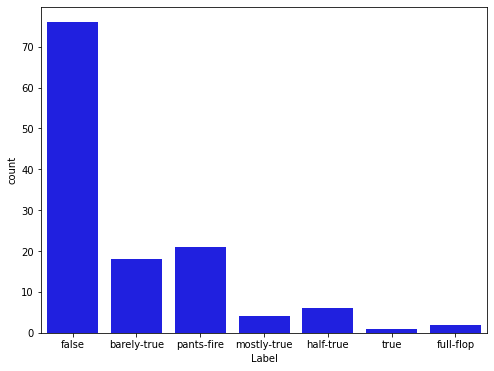

In [ ]:
plt.figure(figsize=(8,6))
p=sns.countplot(df_main["Label"], color='blue')

###Convert Label to Binary values

In [ ]:
df_main['Label'] = df_main['Label'].astype('category')
# Assigning numerical values and storing in another column
df_main['Label_cat'] = df_main['Label'].cat.codes


In [ ]:
df_main['Label_cat']

0      1
1      1
2      0
3      5
4      1
      ..
123    1
124    1
125    1
126    3
127    5
Name: Label_cat, Length: 128, dtype: int8

In [ ]:
cat_to_nums = {"Label":     {"true":1, "false":0, "barely-true": 0, "half-true": 0, "mostly-true": 1,"pants-fire": 0} }
df_main.replace(cat_to_nums, inplace=True)
df_main['Label']


0      0
1      0
2      0
3      0
4      0
      ..
123    0
124    0
125    0
126    0
127    0
Name: Label, Length: 128, dtype: object

In [ ]:
df_main.head()

,title,title_count,veracity,Link,Date,Source,Label,Label_cat
0,A “system glitch” in Wisconsin that “swapped v...,4.0,0,https://www.politifact.com/factchecks/2020/nov...,"mber 10, 2020",Eric Trump,0,1
1,More mail-in ballots were counted in Lancaster...,1.0,0,https://www.politifact.com/factchecks/2020/nov...,"ember 5, 2020",Viral image,0,1
2,"Kamala Harris’ husband said, “I am married to ...",2.0,0,https://www.politifact.com/factchecks/2020/oct...,"ober 22, 2020",Facebook posts,0,0
3,“Wisconsin has more votes than people who are ...,2.0,0,https://www.politifact.com/factchecks/2020/nov...,"ember 4, 2020",Tweets,0,5
4,“The NAACP has received credible information t...,1.0,0,https://www.politifact.com/factchecks/2020/nov...,"ember 7, 2020",Facebook posts,0,1


#Data Cleaning and Text Preprocessing#

As a part of cleaning, we will perform below steps:
1. Remove Special characters
2. Convert text to lower case
3. Tokenization
4. Removing stop words
5. Lemmetization
6. Stemming

In [ ]:
import re

def cleaning(raw_text):
    import nltk
    
    # 1. Remove non-letters/Special Characters
    text = re.sub("[^a-zA-Z]", " ", str(raw_text))
    
    # 2. Convert to lower case.
    text =  text.lower()
    
    # 3. Tokenize.
    text_words = nltk.word_tokenize(text)
    
    # 4. Convert the stopwords list to "set" data type.
    stops = set(nltk.corpus.stopwords.words("english"))
    
    # 5. Remove stop words. 
    words = [w for w in  text_words  if not w in stops]
    
    # 6. Lemmentize 
    wordnet_lem = [ WordNetLemmatizer().lemmatize(w) for w in words ]
    
    # 7. Stemming
    stems = [nltk.stem.SnowballStemmer('english').stem(w) for w in wordnet_lem ]
    
    # 8. Join the stemmed words back into one string separated by space, and return the result.
    return " ".join(stems)

In [ ]:
import time
import nltk
nltk.download('punkt')
nltk.download('wordnet')
# clean training and test data 
# create new column "tokenized"
t1 = time.time()

# Add the processed data to the original data. 
# Perhaps using apply function would be more elegant and concise than using for loop
df_main['clean_text'] = df_main["title"].apply(cleaning) 

t2 = time.time()
print("\nTime to clean, tokenize and stem train data: \n", len(df_main), "news:", (t2-t1)/60, "min")



[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!

Time to clean, tokenize and stem train data: 
 128 news: 0.0013245979944864908 min


#Data Visualization#

In [ ]:
# Final data present in datset after data preprocessing, and cleaning
df_main.head()

,title,title_count,veracity,Link,Date,Source,Label,Label_cat,clean_text
0,A “system glitch” in Wisconsin that “swapped v...,4.0,0,https://www.politifact.com/factchecks/2020/nov...,"mber 10, 2020",Eric Trump,0,1,system glitch wisconsin swap vote biden trump ...
1,More mail-in ballots were counted in Lancaster...,1.0,0,https://www.politifact.com/factchecks/2020/nov...,"ember 5, 2020",Viral image,0,1,mail ballot count lancast counti pa return
2,"Kamala Harris’ husband said, “I am married to ...",2.0,0,https://www.politifact.com/factchecks/2020/oct...,"ober 22, 2020",Facebook posts,0,0,kamala harri husband said marri next presid un...
3,“Wisconsin has more votes than people who are ...,2.0,0,https://www.politifact.com/factchecks/2020/nov...,"ember 4, 2020",Tweets,0,5,wisconsin vote peopl regist vote direct evid f...
4,“The NAACP has received credible information t...,1.0,0,https://www.politifact.com/factchecks/2020/nov...,"ember 7, 2020",Facebook posts,0,1,naacp receiv credibl inform white nationalist ...


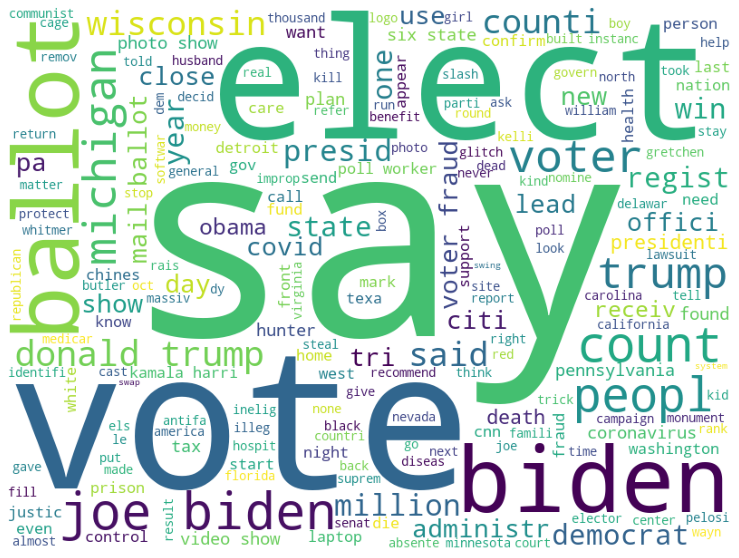

In [ ]:
#Word cloud of Train dataset

from wordcloud import WordCloud, STOPWORDS
def wcloud(data,backgroundcolor = 'white', width = 800, height = 600):
    word_cloud = WordCloud(stopwords = STOPWORDS, background_color = backgroundcolor,
                         width = width, height = height).generate(data)
    plt.figure(figsize = (15, 10))
    plt.imshow(word_cloud)
    plt.axis("off")
    plt.show()
    
wcloud(' '.join(df_main['clean_text']))


As it can be seen above the word 'vote', 'ballot', 'count' and 'elect', 'biden' occured most frequently.

As the latest news from Politico website was pulled it presented most posts related to th US Presendential Election

#Factor Implementation#

In [ ]:
falseNegative = 0
falsePositive = 0
falseMoreThanOne = 0
trueNegative = 0
truePositive = 0
trueMoreThanOne = 0
for index, row in df_main.iterrows():
    if (row.Label == 0):
        if (row.veracity == 1):
            trueNegative += 1
        else:
            falseNegative += 1
    elif (row.Label == 1):
        if (row.veracity == 1):
            truePositive += 1
        else:
            falsePositive += 1
    elif (row.title_count > 1):
        if (row.veracity == 1):
            trueMoreThanOne += 1
        else:
            falseMoreThanOne += 1

print("trueNegative=", trueNegative)
print("falseNegative=", falseNegative)
print("truePositive=", truePositive)
print("falsePositive=", falsePositive)
print("trueMoreThanOne=", trueMoreThanOne)
print("fakeMoreThanOne=", falseMoreThanOne)



trueNegative= 45
falseNegative= 76
truePositive= 3
falsePositive= 2
trueMoreThanOne= 2
fakeMoreThanOne= 0


In [ ]:
col_names = ['title_count', 'Label_cat']
X = df_main[col_names]
Y = df_main['veracity']

In [ ]:

X_train, X_test, Y_train, Y_test = \
    train_test_split(X, Y, test_size=.2)

In [ ]:
from sklearn.linear_model import LogisticRegression
logmodel = LogisticRegression()
logmodel.fit(X_train,Y_train)
predictions = logmodel.predict(X_test)

In [ ]:
from sklearn.metrics import classification_report
print(classification_report(Y_test,predictions))

              precision    recall  f1-score   support

           0       0.73      1.00      0.84        16
           1       1.00      0.40      0.57        10

    accuracy                           0.77        26
   macro avg       0.86      0.70      0.71        26
weighted avg       0.83      0.77      0.74        26



Using Naive Bayes Classifier

In [ ]:
from sklearn.naive_bayes import GaussianNB

In [ ]:
model = GaussianNB()

In [ ]:
model.fit(X_train,Y_train)

GaussianNB(priors=None, var_smoothing=1e-09)

In [ ]:
pred = model.predict(X_test)

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
print("Confusion Matrix: \n")
print(confusion_matrix(Y_test,pred))
print("Classification Report:\n")
print(classification_report(Y_test,pred))
print('Accuracy score for Naive Bayes:\n', accuracy_score(Y_test, pred))


Confusion Matrix: 

[[16  0]
 [ 5  5]]
Classification Report:

              precision    recall  f1-score   support

           0       0.76      1.00      0.86        16
           1       1.00      0.50      0.67        10

    accuracy                           0.81        26
   macro avg       0.88      0.75      0.77        26
weighted avg       0.85      0.81      0.79        26

Accuracy score for Naive Bayes:
 0.8076923076923077


# Research and Findings

To determine the credibility of a news we need to find the news source. A news with credible source will help differentiate it from fake news and real news.

To work on the factor Context veracity, we need to provdie resources for the news. Follwing are the different articles and research papers that helped understanding this concept.

https://www.kaggle.com/ruchi798/how-do-you-recognize-fake-news

https://towardsdatascience.com/identifying-fake-news-the-liar-dataset-713eca8af6ac

 https://www-sciencedirect-com.libaccess.sjlibrary.org/science/article/pii/S1389041719301020



#References

https://www.politifact.com

https://towardsdatascience.com/logistic-regression-a-simplified-approach-using-python-c4bc81a87c31


https://gist.githubusercontent.com/techykajal/dd7f3974f4a4ad3203dfa858abc73cd7/raw/2c366480f1624f96cb2299338500b84fb905c978/Scraping.py

https://towardsdatascience.com/scraping-1000s-of-news-articles-using-10-simple-steps-d57636a49755

https://towardsdatascience.com/comparing-pandas-dataframes-to-one-another-c26853d7dda7

https://stackoverflow.com/questions/12497402/python-pandas-remove-duplicates-by-columns-a-keeping-the-row-with-the-highest

https://stackoverflow.com/questions/12497402/python-pandas-remove-duplicates-by-columns-a-keeping-the-row-with-the-highest


